<a href="https://colab.research.google.com/github/pooyapaydary/Python/blob/main/mini_project_13Nov25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Data cleaning summary (1–2 paragraphs or bullets)

How you:

Standardized sample_time → proper datetime and handled bad/missing ones.

Converted pH, DO_mg_L, temp_C, turbidity_NTU, rain_mm_24h to numeric.

Dealt with values like "ND", "<6.8", "error", "trace", "NaN", "15C", ">".

Cleaned station_metadata (is_active → bool, start_date formats, region / river casing, stripped spaces).

Merged analysis dataset

Read from the CSVs.

Inner/left join on station_id to get a single analysis DataFrame.

Identify & document:

The unknown station (STXX).

Any samples with no station metadata.

How many records get dropped/kept in different join types.

Exploratory analysis

A few concrete questions, e.g.:

How does DO change with rainfall at each station?

Which station has the highest average turbidity? Any obvious storm spikes?

Any station consistently showing low DO (< 2 mg/L) after storms?

Use groupby / agg and produce a small summary table.

Visualizations (3–5 plots)

Time-series line/marker plot: DO over time, colored by station.

Boxplot or violin: pH distribution per station.

Bar chart: mean turbidity per station.

Scatter: rain_mm_24h vs DO_mg_L (maybe highlight low-DO points).



In [145]:
import pandas as pd

# ------------------------
# 1) Water readings table
# ------------------------
water_data = [
    {"sample_id": "S-001", "station_id": "ST01", "sample_time": "2025-01-03 08:15", "pH": "7.2", "DO_mg_L": "8.1", "temp_C": "12.3", "turbidity_NTU": "0.5", "rain_mm_24h": "3.2", "comment": ""},
    {"sample_id": "S-002", "station_id": "ST01", "sample_time": "03-01-2025 14:05", "pH": "7,0", "DO_mg_L": "7.9", "temp_C": "11.8", "turbidity_NTU": "0.7", "rain_mm_24h": "", "comment": "light rain"},
    {"sample_id": "S-003", "station_id": "ST02", "sample_time": "2025/01/04 07:45", "pH": "<6.8", "DO_mg_L": "ND", "temp_C": "10.1", "turbidity_NTU": "1.2", "rain_mm_24h": "0", "comment": "valve leak suspected"},
    {"sample_id": "S-004", "station_id": "ST02", "sample_time": "2025-01-04T15:20", "pH": "error", "DO_mg_L": "6.3", "temp_C": "9.9", "turbidity_NTU": ">", "rain_mm_24h": "5.0", "comment": ""},
    {"sample_id": "S-005", "station_id": "ST03", "sample_time": "2025-13-05 10:00", "pH": "8.9", "DO_mg_L": "10.2", "temp_C": "15C", "turbidity_NTU": "0.3", "rain_mm_24h": "1.1", "comment": "date format??"},
    {"sample_id": "S-006", "station_id": "ST03", "sample_time": "2025-01-06 09:05:00", "pH": " 9.3 ", "DO_mg_L": "4.1", "temp_C": "", "turbidity_NTU": "3.4", "rain_mm_24h": "12.4", "comment": "algae bloom"},
    {"sample_id": "S-007", "station_id": "ST04", "sample_time": "2025-01-06", "pH": "7.05", "DO_mg_L": "8.0 mg/L", "temp_C": "13.2", "turbidity_NTU": "0.9", "rain_mm_24h": "trace", "comment": ""},
    {"sample_id": "S-008", "station_id": "ST04", "sample_time": "2025-01-07 08:00", "pH": "NaN", "DO_mg_L": "7.1", "temp_C": "12.0", "turbidity_NTU": "", "rain_mm_24h": "0.0", "comment": "instrument recalibration"},
    {"sample_id": "S-009", "station_id": "ST05", "sample_time": "07-01-25 16:30", "pH": "6.4", "DO_mg_L": "<2.0", "temp_C": "8.7", "turbidity_NTU": "5.6", "rain_mm_24h": "22.5", "comment": "storm event"},
    {"sample_id": "S-010", "station_id": "ST05", "sample_time": "2025-01-08 07:55", "pH": "6.45", "DO_mg_L": "2.1", "temp_C": "8.4", "turbidity_NTU": "5.1", "rain_mm_24h": "0.0", "comment": ""},
    {"sample_id": "S-011", "station_id": "STXX", "sample_time": "2025-01-08 10:15", "pH": "7.8", "DO_mg_L": "8.7", "temp_C": "14.0", "turbidity_NTU": "0.4", "rain_mm_24h": "0.5", "comment": "unknown station?"},
    {"sample_id": "S-012", "station_id": "ST01", "sample_time": "2025-01-09 09:10", "pH": "7.3", "DO_mg_L": "", "temp_C": "11.9", "turbidity_NTU": "0.6", "rain_mm_24h": "1.0", "comment": ""},
    {"sample_id": "S-013", "station_id": "ST02", "sample_time": "2025-01-09 09:20", "pH": "7.31", "DO_mg_L": "7.3", "temp_C": "11.6", "turbidity_NTU": "0.8", "rain_mm_24h": "1.0", "comment": "duplicate? see S-014"},
    {"sample_id": "S-014", "station_id": "ST02", "sample_time": "2025-01-09 09:20", "pH": "7.3", "DO_mg_L": "7.4", "temp_C": "11.6", "turbidity_NTU": "0.8", "rain_mm_24h": "1.0", "comment": "duplicate? see S-013"},
    {"sample_id": "S-015", "station_id": "ST03", "sample_time": "", "pH": "8.1", "DO_mg_L": "9.0", "temp_C": "13.9", "turbidity_NTU": "0.2", "rain_mm_24h": "0.0", "comment": "missing time"},
    {"sample_id": "S-016", "station_id": "ST03", "sample_time": "2025-01-10 14:40", "pH": "8.15", "DO_mg_L": "8.9", "temp_C": "14.2", "turbidity_NTU": "0.3", "rain_mm_24h": "0", "comment": ""},
    {"sample_id": "S-017", "station_id": "ST04", "sample_time": "10/01/2025 08:10", "pH": "7.0", "DO_mg_L": "7.8", "temp_C": "12.7", "turbidity_NTU": "1.0", "rain_mm_24h": "3.0", "comment": ""},
    {"sample_id": "S-018", "station_id": "ST05", "sample_time": "2025-01-10 08:05", "pH": "6.3", "DO_mg_L": "1.8", "temp_C": "8.0", "turbidity_NTU": "6.0", "rain_mm_24h": "18.0", "comment": "pre-dawn sample"},
    {"sample_id": "S-019", "station_id": "ST01", "sample_time": "2025-01-11 07:55", "pH": "7.4", "DO_mg_L": "8.0", "temp_C": "12.1", "turbidity_NTU": "0.5", "rain_mm_24h": "0.0", "comment": ""},
    {"sample_id": "S-020", "station_id": "ST02", "sample_time": "2025-01-11 08:05", "pH": "7.35", "DO_mg_L": "7.6", "temp_C": "11.5", "turbidity_NTU": "0.7", "rain_mm_24h": "0.0", "comment": ""},
]

wdf = pd.DataFrame(water_data)

# ------------------------
# 2) Station metadata table
# ------------------------
station_data = [
    {"station_id": "ST01", "station_name": "North River - Upstream", "river": "North River", "region": "Devens", "is_active": "TRUE", "latitude": 42.5432, "longitude": -71.6123, "start_date": "2019-03-01"},
    {"station_id": "ST02", "station_name": "north river  - mid ", "river": "north river", "region": "devens", "is_active": "True", "latitude": 42.5411, "longitude": -71.6001, "start_date": "2019/03/01"},
    {"station_id": "ST03", "station_name": "North River-Downstream", "river": "North River", "region": "Devens ", "is_active": "YES", "latitude": 42.5399, "longitude": -71.5902, "start_date": "03-01-2019"},
    {"station_id": "ST04", "station_name": "Ash Brook", "river": "Ash brook", "region": "North Andover", "is_active": "FALSE", "latitude": 42.6777, "longitude": -71.1222, "start_date": "2015-06-15"},
    {"station_id": "ST05", "station_name": "Industrial Canal", "river": "Canal", "region": "devens", "is_active": "true", "latitude": 42.5501, "longitude": -71.6205, "start_date": ""},
]

sdf = pd.DataFrame(station_data)

# Save to CSVs so you can pretend they're "real" files coming from somewhere
wdf.to_csv("water_readings.csv", index=False)
sdf.to_csv("station_metadata.csv", index=False)

print("water_readings.csv and station_metadata.csv created!")
print(wdf.head(), "\n")
print(sdf.head())


water_readings.csv and station_metadata.csv created!
  sample_id station_id       sample_time     pH DO_mg_L temp_C turbidity_NTU  \
0     S-001       ST01  2025-01-03 08:15    7.2     8.1   12.3           0.5   
1     S-002       ST01  03-01-2025 14:05    7,0     7.9   11.8           0.7   
2     S-003       ST02  2025/01/04 07:45   <6.8      ND   10.1           1.2   
3     S-004       ST02  2025-01-04T15:20  error     6.3    9.9             >   
4     S-005       ST03  2025-13-05 10:00    8.9    10.2    15C           0.3   

  rain_mm_24h               comment  
0         3.2                        
1                        light rain  
2           0  valve leak suspected  
3         5.0                        
4         1.1         date format??   

  station_id            station_name        river         region is_active  \
0       ST01  North River - Upstream  North River         Devens      TRUE   
1       ST02     north river  - mid   north river         devens      True   
2 

In [146]:
#reading data
import pandas as pd

dfw=pd.read_csv("water_readings.csv")
dfs=pd.read_csv("station_metadata.csv")

In [147]:
#lets look at water wuality reading table see how messy it is
print(dfw.head())
print("\n")

print(dfw.columns)
print("\n")

print(dfw.info())
print("\n")

print(dfw.tail())
print("\n")

print(dfw.describe())
print("\n")

  sample_id station_id       sample_time     pH DO_mg_L temp_C turbidity_NTU  \
0     S-001       ST01  2025-01-03 08:15    7.2     8.1   12.3           0.5   
1     S-002       ST01  03-01-2025 14:05    7,0     7.9   11.8           0.7   
2     S-003       ST02  2025/01/04 07:45   <6.8      ND   10.1           1.2   
3     S-004       ST02  2025-01-04T15:20  error     6.3    9.9             >   
4     S-005       ST03  2025-13-05 10:00    8.9    10.2    15C           0.3   

  rain_mm_24h               comment  
0         3.2                   NaN  
1         NaN            light rain  
2           0  valve leak suspected  
3         5.0                   NaN  
4         1.1         date format??  


Index(['sample_id', 'station_id', 'sample_time', 'pH', 'DO_mg_L', 'temp_C',
       'turbidity_NTU', 'rain_mm_24h', 'comment'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column         Non-Null Count  

In [148]:
dfw["sample_time"]=dfw["sample_time"].str.strip().str.lower()
dfw["sample_time"]

,sample_time
0,2025-01-03 08:15
1,03-01-2025 14:05
2,2025/01/04 07:45
3,2025-01-04t15:20
4,2025-13-05 10:00
5,2025-01-06 09:05:00
6,2025-01-06
7,2025-01-07 08:00
8,07-01-25 16:30
9,2025-01-08 07:55


In [149]:
#ok, so lookslike everything is object, there are 20 rows in total and 9 columns. there are some nans and some weired charachters in the columns
#lets start with changing the date time to proper format
def try_parser(x):
  try:
    return(parser.parse(x))
  except:
    print("bad date: ",x)
    #return(pd.NaT)


from dateutil import parser
dfw["sample_time"]=dfw["sample_time"].apply(lambda x:try_parser(x))


bad date:  2025-13-05 10:00
bad date:  nan


In [150]:
dfw["sample_time"]
#1 row had invalid date string ‘2025-13-05 10:00’. Month ‘13’ is impossible. Kept as NaT.
#so now date time is fixed
dfw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sample_id      20 non-null     object        
 1   station_id     20 non-null     object        
 2   sample_time    18 non-null     datetime64[ns]
 3   pH             19 non-null     object        
 4   DO_mg_L        19 non-null     object        
 5   temp_C         19 non-null     object        
 6   turbidity_NTU  19 non-null     object        
 7   rain_mm_24h    19 non-null     object        
 8   comment        11 non-null     object        
dtypes: datetime64[ns](1), object(8)
memory usage: 1.5+ KB


In [151]:
#ok lets make sample-id index
dfw.set_index("sample_id")
#lets look at station_id
dfw["station_id"].unique()
#we have stxx, just making a mental note, the rest of the station ids look ok, no cleaning needed

array(['ST01', 'ST02', 'ST03', 'ST04', 'ST05', 'STXX'], dtype=object)

In [152]:
#lets look at pH
dfw["pH"].unique()


array(['7.2', '7,0', '<6.8', 'error', '8.9', ' 9.3 ', '7.05', nan, '6.4',
       '6.45', '7.8', '7.3', '7.31', '8.1', '8.15', '7.0', '6.3', '7.4',
       '7.35'], dtype=object)

In [153]:
from numpy import nan
#we have errors we have < sign. we are going to turn them into Nans since <6.8 we cant be confident about the actual number

#lets do it with a function. num_cleaner will be used for all the number columns, all the columns that we are expecting numbers only
import re

def num_cleaner_(x):
  try:

    x=x.strip().lower()
    x=re.sub(r"[^0-9,.<>]","",x)
    x=re.sub(r"[,]",".",x)
    if ((">" or "<") in x):
      return (None)
    else:
        x=float(x)
        return(x)
  except:
    return(None)



dfw["pH"]=dfw["pH"].apply(num_cleaner_)


In [154]:
#lets look at the after cleaning of pH
dfw["pH"].unique()

array([7.2 , 7.  ,  nan, 8.9 , 9.3 , 7.05, 6.4 , 6.45, 7.8 , 7.3 , 7.31,
       8.1 , 8.15, 6.3 , 7.4 , 7.35])

In [155]:
#ok, looks like its working lets see if it works for other num-cols
num_cols=['DO_mg_L', 'temp_C',
       'turbidity_NTU', 'rain_mm_24h']

for i in num_cols:
  dfw[i]=dfw[i].apply(num_cleaner_)


In [156]:
#lets look at the dfw now
print(dfw.info())
print("\n")

print(dfw.head())
print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sample_id      20 non-null     object        
 1   station_id     20 non-null     object        
 2   sample_time    18 non-null     datetime64[ns]
 3   pH             17 non-null     float64       
 4   DO_mg_L        17 non-null     float64       
 5   temp_C         19 non-null     float64       
 6   turbidity_NTU  18 non-null     float64       
 7   rain_mm_24h    18 non-null     float64       
 8   comment        11 non-null     object        
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 1.5+ KB
None


  sample_id station_id         sample_time   pH  DO_mg_L  temp_C  \
0     S-001       ST01 2025-01-03 08:15:00  7.2      8.1    12.3   
1     S-002       ST01 2025-03-01 14:05:00  7.0      7.9    11.8   
2     S-003       ST02 2025-01-04 07:45:00  NaN      Na

In [157]:
# but what about STXX? we are going to create a valid station column and make it boolean to flag
dfw["valid_stations"]=dfw["station_id"]!="STXX"
dfw["valid_stations"]




,valid_stations
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,True


In [158]:
#now we should address the commet section. lets make extra columns for flagging comments
#but what are our 'flag' words.
#we will make a list of all the words in the comments section after uniforming them then wewill see the frequency of the words  and decide
#which ones will be our flag words

from collections import Counter

dfw["clean_comments"]=dfw["comment"].str.lower().str.strip()
words=dfw["clean_comments"].str.replace(r"[^\w\s]", " ").str.split()
word_counter= Counter ()
for lst in words.dropna():
    word_counter.update(lst)

word_counter.most_common(11)




[('duplicate?', 2),
 ('see', 2),
 ('light', 1),
 ('rain', 1),
 ('valve', 1),
 ('leak', 1),
 ('suspected', 1),
 ('date', 1),
 ('format??', 1),
 ('algae', 1),
 ('bloom', 1)]

In [159]:
#alright lets have "duplicate", "rain" "algea"and "leak" as flag columns
flags=["duplicate", "rain", "algea","leak"]
for i in flags:
    dfw[f"flag_{i}"]=dfw["clean_comments"].str.contains("i")

In [160]:
#lets sort the data frame chronaligacally
dfw=dfw.sort_values(["station_id", "sample_time"])
dfw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 0 to 10
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sample_id       20 non-null     object        
 1   station_id      20 non-null     object        
 2   sample_time     18 non-null     datetime64[ns]
 3   pH              17 non-null     float64       
 4   DO_mg_L         17 non-null     float64       
 5   temp_C          19 non-null     float64       
 6   turbidity_NTU   18 non-null     float64       
 7   rain_mm_24h     18 non-null     float64       
 8   comment         11 non-null     object        
 9   valid_stations  20 non-null     bool          
 10  clean_comments  11 non-null     object        
 11  flag_duplicate  11 non-null     object        
 12  flag_rain       11 non-null     object        
 13  flag_algea      11 non-null     object        
 14  flag_leak       11 non-null     object        
dtypes: bool(1), d

In [161]:
#dfw is clean
dfw.head(2)

,sample_id,station_id,sample_time,pH,DO_mg_L,temp_C,turbidity_NTU,rain_mm_24h,comment,valid_stations,clean_comments,flag_duplicate,flag_rain,flag_algea,flag_leak
0,S-001,ST01,2025-01-03 08:15:00,7.2,8.1,12.3,0.5,3.2,NaN,True,NaN,NaN,NaN,NaN,NaN
11,S-012,ST01,2025-01-09 09:10:00,7.3,NaN,11.9,0.6,1.0,NaN,True,NaN,NaN,NaN,NaN,NaN


In [162]:
#now lets look at dfs

print(dfs.info())
print("\n")

print(dfs.head())
print("\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_id    5 non-null      object 
 1   station_name  5 non-null      object 
 2   river         5 non-null      object 
 3   region        5 non-null      object 
 4   is_active     5 non-null      object 
 5   latitude      5 non-null      float64
 6   longitude     5 non-null      float64
 7   start_date    4 non-null      object 
dtypes: float64(2), object(6)
memory usage: 452.0+ bytes
None


  station_id            station_name        river         region is_active  \
0       ST01  North River - Upstream  North River         Devens      TRUE   
1       ST02     north river  - mid   north river         devens      True   
2       ST03  North River-Downstream  North River        Devens        YES   
3       ST04               Ash Brook    Ash brook  North Andover     FALSE   
4       ST05    

In [163]:
dfs.columns

Index(['station_id', 'station_name', 'river', 'region', 'is_active',
       'latitude', 'longitude', 'start_date'],
      dtype='object')

In [164]:
# looks like is_active should turn to boolean, start date should turn to datetime
dfs["is_active"]=dfs["is_active"].apply(lambda x: bool(x) if pd.notnull(x) else None)
dfs["start_date"]=dfs["start_date"].apply(lambda x: parser.parse(x) if pd.notnull(x) else None)
#now lets clean the string columns
str_cols=[ 'river', 'region']




def str_cleaner_(x):
  x=x.lower().strip()
  x=re.sub(r"[^A-Za-z_]", "",x)
  return(x)


for i in str_cols:
  dfs[i]=dfs[i].apply(lambda x: str_cleaner_(x))

In [165]:
#ok now both are clean
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station_id    5 non-null      object        
 1   station_name  5 non-null      object        
 2   river         5 non-null      object        
 3   region        5 non-null      object        
 4   is_active     5 non-null      bool          
 5   latitude      5 non-null      float64       
 6   longitude     5 non-null      float64       
 7   start_date    4 non-null      datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(2), object(4)
memory usage: 417.0+ bytes


In [166]:
print(dfs.columns)
print(dfw.columns)

Index(['station_id', 'station_name', 'river', 'region', 'is_active',
       'latitude', 'longitude', 'start_date'],
      dtype='object')
Index(['sample_id', 'station_id', 'sample_time', 'pH', 'DO_mg_L', 'temp_C',
       'turbidity_NTU', 'rain_mm_24h', 'comment', 'valid_stations',
       'clean_comments', 'flag_duplicate', 'flag_rain', 'flag_algea',
       'flag_leak'],
      dtype='object')


In [167]:
df=pd.merge(dfs, dfw, on="station_id", how="inner")

In [168]:
df.head()

,station_id,station_name,river,region,is_active,latitude,longitude,start_date,sample_id,sample_time,...,temp_C,turbidity_NTU,rain_mm_24h,comment,valid_stations,clean_comments,flag_duplicate,flag_rain,flag_algea,flag_leak
0,ST01,North River - Upstream,northriver,devens,True,42.5432,-71.6123,2019-03-01,S-001,2025-01-03 08:15:00,...,12.3,0.5,3.2,NaN,True,NaN,NaN,NaN,NaN,NaN
1,ST01,North River - Upstream,northriver,devens,True,42.5432,-71.6123,2019-03-01,S-012,2025-01-09 09:10:00,...,11.9,0.6,1.0,NaN,True,NaN,NaN,NaN,NaN,NaN
2,ST01,North River - Upstream,northriver,devens,True,42.5432,-71.6123,2019-03-01,S-019,2025-01-11 07:55:00,...,12.1,0.5,0.0,NaN,True,NaN,NaN,NaN,NaN,NaN
3,ST01,North River - Upstream,northriver,devens,True,42.5432,-71.6123,2019-03-01,S-002,2025-03-01 14:05:00,...,11.8,0.7,NaN,light rain,True,light rain,True,True,True,True
4,ST02,north river - mid,northriver,devens,True,42.5411,-71.6001,2019-03-01,S-003,2025-01-04 07:45:00,...,10.1,1.2,0.0,valve leak suspected,True,valve leak suspected,False,False,False,False


In [169]:
#lets answer some questions
#How does DO change with rainfall at each station?

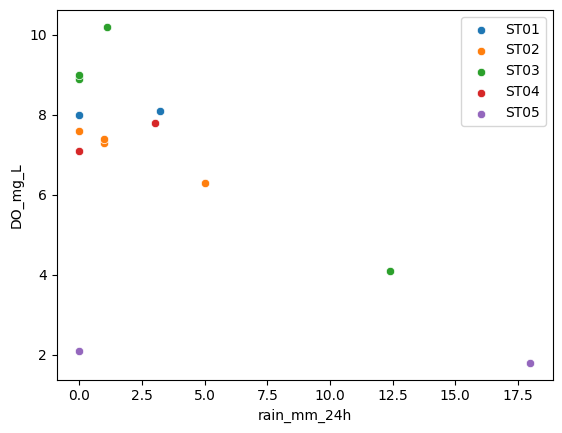

In [170]:
#lets seperate valid station names in a col:
st_cols=df["station_id"].unique()


import seaborn as sns
for i in st_cols:
    sns.scatterplot(df[df["station_id"]==i], x="rain_mm_24h", y="DO_mg_L", label=i)
#looks like as rain increases DO decreases but the number of data points is too small to make a conclusion

Which station has the highest average turbidity? Any obvious storm spikes?

Any station consistently showing low DO (< 2 mg/L) after storms?

Use groupby / agg and produce a small summary table.

Visualizations (3–5 plots)

Time-series line/marker plot: DO over time, colored by station.

Boxplot or violin: pH distribution per station.

Bar chart: mean turbidity per station.

Scatter: rain_mm_24h vs DO_mg_L (maybe highlight low-DO points).

Tiny conclusion section



In [171]:
#Which station has the highest average turbidity? Any obvious storm spikes?

df.groupby("station_id")["turbidity_NTU"].agg("mean")

,turbidity_NTU
station_id,
ST01,0.575000
ST02,0.875000
ST03,1.050000
ST04,0.950000
ST05,5.566667


In [172]:
df["comment"].unique()

array([nan, 'light rain', 'valve leak suspected', 'duplicate? see S-014',
       'duplicate? see S-013', 'algae bloom', 'date format??',
       'missing time', 'instrument recalibration', 'pre-dawn sample',
       'storm event'], dtype=object)

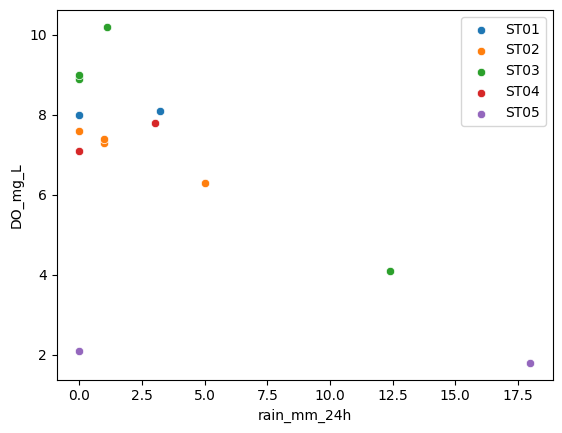

In [173]:
#Any station consistently showing low DO (< 2 mg/L) after storms?
for i in st_cols:
    sns.scatterplot(data=df[df["station_id"]==i],x="rain_mm_24h", y=df["DO_mg_L"], label=i)

    #none of them!

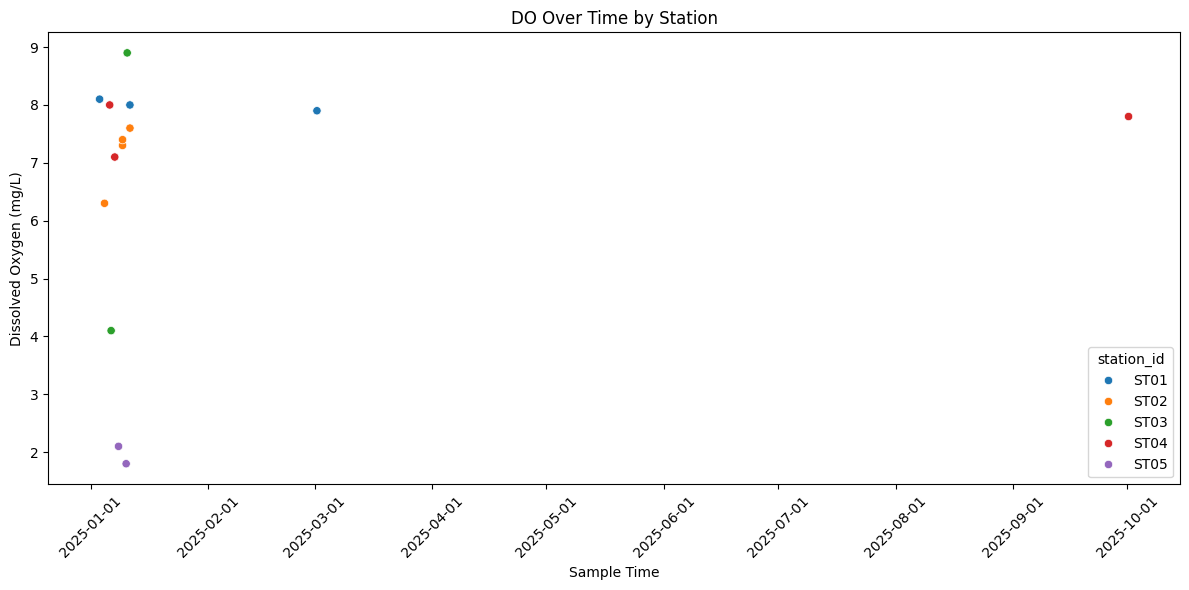

In [174]:
#Time-series line/marker plot: DO over time, colored by station.
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

sns.scatterplot(data=df ,x="sample_time", y="DO_mg_L", hue="station_id")
    #plt.xscale("log")
    #plt.yscale("log")

import matplotlib.dates as mdates


#first time using these
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel("Sample Time")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.title("DO Over Time by Station")
plt.tight_layout()

plt.show()

/tmp/ipython-input-2515337750.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


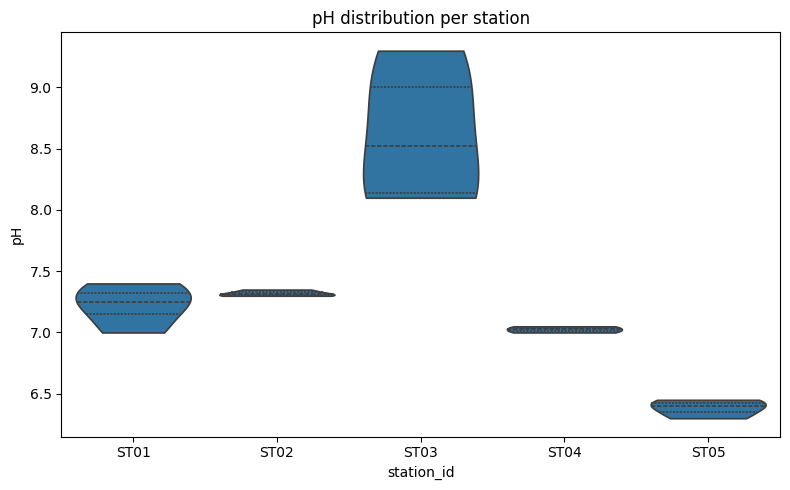

In [191]:
#Boxplot or violin: pH distribution per station
plt.figure(figsize=(8,5))

sns.violinplot(
    data=df,
    x="station_id",
    y="pH",
    inner="quartile",   # show Q1/median/Q3
    scale="width",      # same width for all
    cut=0               # don’t extend past min/max
)

plt.title("pH distribution per station")
plt.show()

<Axes: xlabel='station_id', ylabel='turbidity_NTU'>

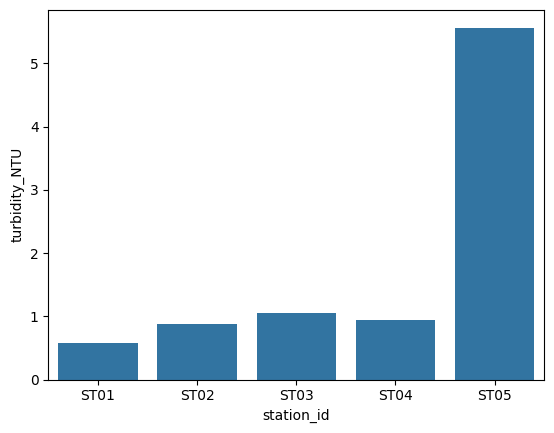

In [207]:
#Bar chart: mean turbidity per station.
df_turb = df.groupby("station_id", as_index=False)["turbidity_NTU"].mean()
sns.barplot(data=df_turb, x="station_id", y="turbidity_NTU")

In [205]:
df_ = df.groupby("station_id", as_index=False)["turbidity_NTU"].agg("mean")
df_

,station_id,turbidity_NTU
0,ST01,0.575000
1,ST02,0.875000
2,ST03,1.050000
3,ST04,0.950000
4,ST05,5.566667
